# 4.2 Supervised Learning with Random Forest

In [2]:
import os
import sys
import re
import csv
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

## Load image paths from google drive. To use the local files, change `google_path` to `.`

In [3]:
google_path = '/content/drive/MyDrive'
path = os.path.join(google_path, 'QC')
train_test_path = os.path.join(path, 'split')
mask_path = os.path.join(path, "mask")
rgb_path = os.path.join(path, "rgb")

# Load training and validation csv files
def load_subjects(csv_path):
    with open(csv_path, newline='') as f:
        reader = csv.reader(f)
        subjects = list(reader)
    return subjects[1:]

train_subjects = load_subjects(os.path.join(train_test_path, 'train_subjects.csv'))
val_subjects = load_subjects(os.path.join(train_test_path, 'validate_subjects.csv'))

## Load images and masks； Extract and downsample pixels

In [10]:
from sklearn.utils import resample

# Match images with the labels in the csv file
def get_image_mask_pairs(subjects):
    images = []
    masks = []
    for patient in subjects:
        for file in os.listdir(rgb_path):
            if re.match(patient[0], file):
                images.append(os.path.join(rgb_path, file))
                masks.append(os.path.join(mask_path, file))
    return images, masks

train_images, train_masks = get_image_mask_pairs(train_subjects)
val_images, val_masks = get_image_mask_pairs(val_subjects)


# Load and preprocess images and masks
def load_and_preprocess(rgb_path, mask_path, target_size=(256, 256), threshold_value=2):

    img = cv.imread(rgb_path, cv.IMREAD_GRAYSCALE)
    img_resized = cv.resize(img, target_size)

    mask_color = cv.imread(mask_path, cv.IMREAD_COLOR)
    mask_resized = cv.resize(mask_color, target_size)
    mask_channel = mask_resized[:, :, 0]
    _, mask_bin = cv.threshold(mask_channel, threshold_value, 255, cv.THRESH_BINARY)
    mask_bin = (mask_bin // 255).astype(np.uint8)

    img_flat = img_resized.flatten().reshape(-1, 1)
    mask_flat = mask_bin.flatten()
    return img_flat, mask_flat, img_resized, mask_bin


def extract_downsampled_pixel_labels(images, masks, target_size=(256,256), sample_fraction=0.05, threshold_value=2):

    X_list, Y_list = [], []

    for img_path, mask_path in zip(images, masks):
        img_flat, mask_flat, _, _ = load_and_preprocess(img_path, mask_path, target_size, threshold_value)

        # Extract nuclei and background indices
        fg_indices = np.where(mask_flat == 1)[0]
        bg_indices = np.where(mask_flat == 0)[0]

        if len(fg_indices) == 0 or len(bg_indices) == 0:
            continue

        n_samples = int(sample_fraction * min(len(fg_indices), len(bg_indices)))

        # Sample equally from both classes
        fg_sampled = resample(fg_indices, n_samples=n_samples, replace=False)
        bg_sampled = resample(bg_indices, n_samples=n_samples, replace=False)

        sampled_indices = np.concatenate([fg_sampled, bg_sampled])
        X_list.append(img_flat[sampled_indices])
        Y_list.append(mask_flat[sampled_indices])

    # Combine all samples
    X_balanced = np.concatenate(X_list).reshape(-1, 1)
    Y_balanced = np.concatenate(Y_list)

    return X_balanced, Y_balanced

## Train the random forest model

In [11]:
X_down_train, Y_down_train = extract_downsampled_pixel_labels(train_images, train_masks, sample_fraction=0.05)
X_down_val, Y_down_val = extract_downsampled_pixel_labels(val_images, val_masks, sample_fraction=0.05)

# Apply a max depth to avoid the overfitting
clf_down = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, max_depth=30)
clf_down.fit(X_down_train, Y_down_train)

Y_down_train_pred = clf_down.predict(X_down_train)
Y_down_val_pred = clf_down.predict(X_down_val)

## Evaluate the model with ACC, AUC and other metrics

Training Accuracy: 0.6903083007505281
Training AUC: 0.752130596576896
Training Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70   1335060
           1       0.70      0.66      0.68   1335060

    accuracy                           0.69   2670120
   macro avg       0.69      0.69      0.69   2670120
weighted avg       0.69      0.69      0.69   2670120

Validation Accuracy: 0.710973432940132
Validation AUC: 0.7724587713338638
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72    423532
           1       0.72      0.68      0.70    423532

    accuracy                           0.71    847064
   macro avg       0.71      0.71      0.71    847064
weighted avg       0.71      0.71      0.71    847064



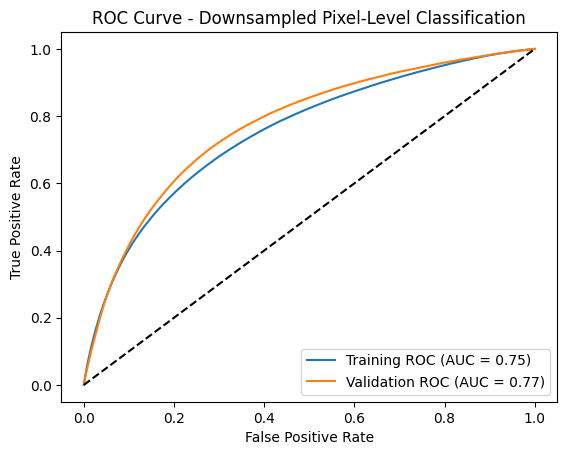

In [12]:
# Compute predicted probabilities for patch-based classifier
print("Training Accuracy:", accuracy_score(Y_down_train, Y_down_train_pred))
print("Training AUC:", roc_auc_score(Y_down_train, clf_down.predict_proba(X_down_train)[:, 1]))
print("Training Classification Report:")
print(classification_report(Y_down_train, Y_down_train_pred, zero_division=0))
print("Validation Accuracy:", accuracy_score(Y_down_val, Y_down_val_pred))
print("Validation AUC:", roc_auc_score(Y_down_val, clf_down.predict_proba(X_down_val)[:, 1]))
print("Validation Classification Report:")
print(classification_report(Y_down_val, Y_down_val_pred, zero_division=0))

# Plot ROC Curves
fpr_train, tpr_train, _ = roc_curve(Y_down_train, clf_down.predict_proba(X_down_train)[:, 1])
fpr_val, tpr_val, _ = roc_curve(Y_down_val, clf_down.predict_proba(X_down_val)[:, 1])

plt.figure()
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {roc_auc_score(Y_down_train, clf_down.predict_proba(X_down_train)[:,1]):.2f})')
plt.plot(fpr_val, tpr_val, label=f'Validation ROC (AUC = {roc_auc_score(Y_down_val, clf_down.predict_proba(X_down_val)[:,1]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Downsampled Pixel-Level Classification")
plt.legend(loc="lower right")
plt.show()

## Show sample images

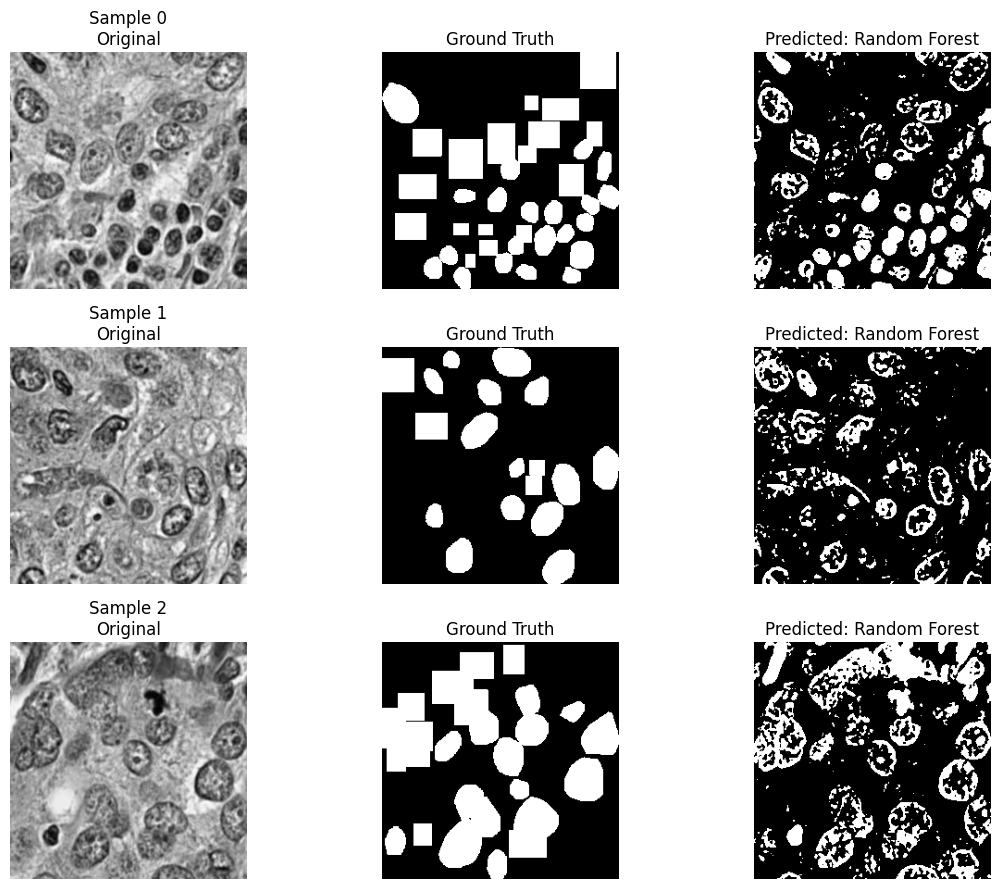

In [13]:
def predict_mask_from_image(image_path, model, target_size=(256,256)):

    # Read the image and resize it
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    img_resized = cv.resize(img, target_size)
    X = img_resized.flatten().reshape(-1, 1)

    # Predict labels (0 or 1) for each pixel
    y_pred = model.predict(X)
    # Reshape predictions to the original image dimensions
    mask_pred = y_pred.reshape(target_size)
    mask_pred_vis = (mask_pred * 255).astype(np.uint8)
    return mask_pred_vis

def get_ground_truth_mask(mask_path, target_size=(256,256), threshold_value=2):

    mask_color = cv.imread(mask_path, cv.IMREAD_COLOR)
    mask_resized = cv.resize(mask_color, target_size)

    mask_channel = mask_resized[:, :, 0]
    # Apply the manual threshold
    _, mask_bin = cv.threshold(mask_channel, threshold_value, 255, cv.THRESH_BINARY)
    return mask_bin

# Define a list of sample indices to display (first 3 images in validation set)
sample_indices = [0, 1, 2]

# Set target image size for display
target_size = (256, 256)

# Create a figure with 3 rows and 3 columns: Original, Ground Truth, and Predicted
num_samples = len(sample_indices)
plt.figure(figsize=(12, 3*num_samples))

for idx, sample_index in enumerate(sample_indices):
    image_path = val_images[sample_index]
    mask_path = val_masks[sample_index]

    # Predict the mask using the trained classifier (clf_down)
    pred_mask = predict_mask_from_image(image_path, clf_down, target_size=target_size)

    # Get the ground truth binary mask
    gt_mask = get_ground_truth_mask(mask_path, target_size=target_size, threshold_value=2)

    # Read and resize the original image for display
    orig_img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    orig_img_resized = cv.resize(orig_img, target_size)

    # Plot the original image, ground truth mask, and predicted mask
    plt.subplot(num_samples, 3, idx*3 + 1)
    plt.imshow(orig_img_resized, cmap='gray')
    plt.title(f"Sample {sample_index}\nOriginal")
    plt.axis("off")

    plt.subplot(num_samples, 3, idx*3 + 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(num_samples, 3, idx*3 + 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted: Random Forest")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Output the overall DICE value

In [14]:
# Initialize total vectors
all_true = []
all_pred = []

# Loop through all validation images
for img_path, mask_path in zip(val_images, val_masks):
    # Preprocess image and mask
    img_flat, mask_flat, _, _ = load_and_preprocess(img_path, mask_path, target_size=(256, 256), threshold_value=2)

    # Predict
    pred_flat = clf_down.predict(img_flat)
    pred_bin = (pred_flat > 0.5).astype(np.uint8)

    # Collect all pixels
    all_true.append(mask_flat)
    all_pred.append(pred_bin)

# Concatenate all into single vectors
all_true = np.concatenate(all_true)
all_pred = np.concatenate(all_pred)

# Compute overall Dice
intersection = np.logical_and(all_true, all_pred).sum()
total = all_true.sum() + all_pred.sum()
overall_dice = 2 * intersection / total if total != 0 else 1.0

print(f"Overall Dice Coefficient across validation set: {overall_dice:.4f}")

Overall Dice Coefficient across validation set: 0.6303


## Iterate groups to compare the performance on different pathological structures

In [ ]:
# Load imask using your logic
def load_imask(mask_path, target_size=(256, 256)):
    mask = cv.imread(mask_path, cv.IMREAD_COLOR)
    mask_resized = cv.resize(mask, target_size)
    imask = mask_resized[:, :, 1] * mask_resized[:, :, 2]
    return imask

# Collect all valid group classes (excluding 0 and 253)
valid_classes = set()
for mpath in val_masks:  # or train_masks
    imask = load_imask(mpath)
    unique = np.unique(imask)
    valid = set(unique) - {0, 253}
    valid_classes.update(valid)

valid_classes = sorted(valid_classes)
print("Valid group classes found:", valid_classes)

# Visualize each group (one image and mask per group)
for group in valid_classes:
    print(f"\nShowing examples for group {group}:")

    shown = 0
    for img_path, mpath in zip(val_images, val_masks):  # or train_images/masks
        imask = load_imask(mpath)
        if group not in imask:
            continue

        # Create binary mask for this group
        group_mask = (imask == group).astype(np.uint8) * 255

        # Load grayscale image
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        img_resized = cv.resize(img, (256, 256))

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(img_resized, cmap='gray')
        axs[0].set_title('Original Image')
        axs[1].imshow(group_mask, cmap='gray')
        axs[1].set_title(f'Group {group} Mask')
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

        shown += 1
        if shown == 2:  # Show 2 samples per group
            break

# Output deleted to save space